**Outline**

1. Append the datasets together, make sure the columns line up
2. Clean them.
3. Run test to see if the likelihood of winnning first serve before you hit it is higher than that of the second serve.
    - if so, players should just use their first serve (mixture) for their second serve.
        - mixture is defined as the set of speed, placement, and spin that spans the first serve.
            - spin is unobserved (I think)
                -Generally, you can guess that wide deuce serves are slice and wide ad serves are kick (topspin)
    - what is the psychological impact of double faulting? Does this justify being more conservative with your second serve?

**Other goals**
1. See what the optimum speed of serve to hit is in terms of likelihood to win at time of striking the ball
    - Unforturnately, I dont know the speed of serves that miss.
        - Would I need to do a stepwise regression here? Or is it instrumental variables?
            - looking to find another dataset that has shows the effect serve speed has on liklihood of making your serve and integrate it into the analysis.
2. Is there an interactive term? Do past serve types (as defined by placement, speed) determine how effective later serves are?
    - Could create some index of diversity of serves, see if it's predictive of average serve success of a match
    - Are more rare serve types (defined by speed/placement) more effective? 
3. Are certain serve types more effective in big moments?
4. Should I try regressions if I finish early?
    - could regress serve speed/effectiveness on number of points
        - people tend to get more tired as the match goes on
    - Could create a more complete logit model.
5. See if there is a difference in the men's and women's data
6. Heatmap of court/serving box separated into wide, center, T
7. Could interpolate point number
8. Take the average serve win percentage and average make percentage by player in a match, and compare those.

break out later serves into own DF and compare corr coefficient and compare with earleir serves

know what successful serves look like, use clustering. kNow speed and direction, plot that data, and for the color, plot whether the serve was successful or not. You might see some separation in taht 2d plot and see the clusters. can see the average and see what gave that cluster it's 


In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multitest import multipletests


%matplotlib inline

<IPython.core.display.Javascript object>

Import the data. This is a csv file of summary statistics from a project wherein volunteers charted tennis matches, point by point.

In [3]:
data_path = "data/charting-m-stats-Overview.csv"
df = pd.read_csv(data_path, encoding="ISO-8859-1")

<IPython.core.display.Javascript object>

In [4]:
df.head(10)

,match_id,player,set,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,bk_pts,bp_saved,return_pts,return_pts_won,winners,winners_fh,winners_bh,unforced,unforced_fh,unforced_bh
0,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,1,Total,69,2,1,32,25,37,21,5,4,63,36,28,10,16,16,6,9
1,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,2,Total,63,2,2,41,20,22,7,12,4,69,23,14,8,4,26,15,9
2,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,1,1,26,2,0,15,10,11,6,2,1,18,13,10,3,5,6,2,4
3,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,2,1,18,0,0,11,3,7,2,3,0,26,10,4,2,2,10,7,3
4,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,1,2,24,0,0,10,9,14,8,1,1,26,10,9,3,6,6,2,4
5,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,2,2,26,2,1,18,12,8,4,4,2,24,7,8,5,1,8,4,3
6,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,1,3,19,0,1,7,6,12,7,2,2,19,13,9,4,5,4,2,1
7,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,2,3,19,0,1,12,5,7,1,5,2,19,6,2,1,1,8,4,3
8,19780125-M-Pepsi_Grand_Slam-SF-Brian_Gottfried...,1,Total,55,0,1,32,21,23,9,9,5,49,14,11,7,4,31,9,21
9,19780125-M-Pepsi_Grand_Slam-SF-Brian_Gottfried...,2,Total,49,0,2,31,25,18,10,1,0,55,25,15,8,7,21,7,12


<IPython.core.display.Javascript object>

### Add some more info to the dataframe, like year and players (from the match_id), after adding some serve statistics columns

In [5]:
df["year"] = df["match_id"].str[0:4].astype(int)

df["serve_pts"] = df["serve_pts"] + df["dfs"]
df["first_out"] = df["serve_pts"] - df["first_in"]
df["first_make_pct"] = df["first_in"] / df["serve_pts"]
df["first_win_pct"] = df["first_won"] / df["first_in"]
df["first_make_win"] = df["first_make_pct"] * df["first_win_pct"]


df["second_total"] = df["second_in"] + df["dfs"]
df["second_out"] = df["dfs"]
df["second_make_pct"] = df["second_in"] / df["second_total"]
df["second_win_pct"] = df["second_won"] / df["second_in"]
df["second_make_win"] = df["second_make_pct"] * df["second_win_pct"]
df['second_success']= df['second_make_win'] * (1-df['first_make_pct']) #this is the likelihood of winning the point on your second serve before you hit your first


<IPython.core.display.Javascript object>

In [6]:
#df['player_id']=df['match_id'].str.split('-').str[(df['player']%2)*-1-1]
#df['player_id']=df['match_id'].str.split('-')
#df['player_id']=df['player_id'].str[(df['player']%2)*-1-1]
df['player_id']=None
df.loc[df['player']==2, ['player_id']]=df["match_id"].str.split("-").str[-1]
df.loc[df['player']==1, ['player_id']]=df["match_id"].str.split("-").str[-2]


<IPython.core.display.Javascript object>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19298 entries, 0 to 19297
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_id         19298 non-null  object 
 1   player           19298 non-null  int64  
 2   set              19298 non-null  object 
 3   serve_pts        19298 non-null  int64  
 4   aces             19298 non-null  int64  
 5   dfs              19298 non-null  int64  
 6   first_in         19298 non-null  int64  
 7   first_won        19298 non-null  int64  
 8   second_in        19298 non-null  int64  
 9   second_won       19298 non-null  int64  
 10  bk_pts           19298 non-null  int64  
 11  bp_saved         19298 non-null  int64  
 12  return_pts       19298 non-null  int64  
 13  return_pts_won   19298 non-null  int64  
 14  winners          19298 non-null  int64  
 15  winners_fh       19298 non-null  int64  
 16  winners_bh       19298 non-null  int64  
 17  unforced    

<IPython.core.display.Javascript object>

### Use only the stats that covered the whole match (where the set variable is labeled 'Total'), then make total_serve, which is only the variables that have to do with serve statistics

In [8]:
total = df[df["set"] == "Total"]

<IPython.core.display.Javascript object>

In [9]:
total_serve = total[
    [
        'match_id',
        'player',
        'player_id',
        'serve_pts',
        'aces',
        'dfs',
        'first_in',
        'first_won',
        'second_in',
        'second_won',
        'year',
        'first_out',
        'first_make_pct',
        'first_win_pct',
        "first_make_win",
        'second_total',
        'second_out',
        'second_make_pct',
        'second_win_pct',
        "second_make_win",
        'second_success'
    ]
]


<IPython.core.display.Javascript object>

In [10]:
total.player_id.unique().size

542

<IPython.core.display.Javascript object>

### Group by player id, sum up the serve stats for each match for each player, then calculate means

I would also like to add a year range to each players list that says (min year, max year)

In [11]:
player_sums = total_serve[
    [
        'match_id',
        'player_id',
        'serve_pts',
        'aces',
        'dfs',
        'first_in',
        'first_won',
        'second_in',
        'second_won',
        'year',
        'first_out',
        'second_total',
        'second_out',
    ]
]


<IPython.core.display.Javascript object>

In [12]:
player_sums["matches_no"] = 1
player_sums = player_sums.groupby("player_id").sum()

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

In [13]:
player_sums["first_make_pct"] = player_sums["first_in"] / player_sums["serve_pts"]
player_sums["first_win_pct"] = player_sums["first_won"] / player_sums["first_in"]
player_sums["first_make_win"] = (
    player_sums["first_make_pct"] * player_sums["first_win_pct"]
)


player_sums["second_make_pct"] = player_sums["second_in"] / player_sums["second_total"]
player_sums["second_win_pct"] = player_sums["second_won"] / player_sums["second_in"]
player_sums["second_make_win"] = (
    player_sums["second_make_pct"] * player_sums["second_win_pct"]
)
player_sums["second_success"] = player_sums["second_make_win"] * (
    1 - player_sums["first_make_pct"]
)  # this is the likelihood of winning the point on your second serve before you hit your first

player_sums["make_win_diff"] = (
    player_sums["second_make_win"] - player_sums["first_make_win"]
)  # should this be division?

<IPython.core.display.Javascript object>

In [14]:
#look at the top 10 first servers (by a few different metrics)
player_sums.sort_values(by="serve_pts", ascending=False).head(150).sort_values(by="first_win_pct", ascending=False).head(10)
player_sums.sort_values(by="serve_pts", ascending=False).head(150).sort_values(by="first_make_win", ascending=False).head(10)


,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,year,first_out,second_total,second_out,matches_no,first_make_pct,first_win_pct,first_make_win,second_make_pct,second_win_pct,second_make_win,second_success,make_win_diff
player_id,,,,,,,,,,,,,,,,,,,,
John_Isner,3349,633,76,2306,1777,967,525,74603,1043,1043,76,37,0.688564,0.770598,0.530606,0.927133,0.542916,0.503356,0.156763,-0.027250
Reilly_Opelka,1016,249,19,674,519,323,182,20190,342,342,19,10,0.663386,0.770030,0.510827,0.944444,0.563467,0.532164,0.179134,0.021337
Ivo_Karlovic,2504,555,117,1568,1278,819,424,54427,936,936,117,27,0.626198,0.815051,0.510383,0.875000,0.517705,0.452991,0.169329,-0.057392
Nick_Kyrgios,3558,622,128,2284,1777,1146,608,74630,1274,1274,128,37,0.641934,0.778021,0.499438,0.899529,0.530541,0.477237,0.170883,-0.022201
Kevin_Anderson,2139,312,63,1351,1047,725,344,40328,788,788,63,20,0.631604,0.774981,0.489481,0.920051,0.474483,0.436548,0.160823,-0.052933
Bernard_Tomic,2010,219,41,1337,974,632,315,48350,673,673,41,24,0.665174,0.728497,0.484577,0.939079,0.498418,0.468053,0.156716,-0.016524
Andy_Roddick,4820,695,119,3054,2333,1647,846,100290,1766,1766,119,50,0.633610,0.763916,0.484025,0.932616,0.513661,0.479049,0.175519,-0.004976
Milos_Raonic,4048,672,151,2437,1949,1460,774,94745,1611,1611,151,47,0.602026,0.799754,0.481472,0.906269,0.530137,0.480447,0.191206,-0.001025
Matteo_Berrettini,1201,140,33,729,576,439,244,34320,472,472,33,17,0.606994,0.790123,0.479600,0.930085,0.555809,0.516949,0.203164,0.037349


<IPython.core.display.Javascript object>

first_make_win tracks fairly closely with who I think of as the top servers in the game, but we can already see that a possible source of bias is that worse players (who are relatively good servers) will have their win percentages inflated. Is does this affect the analysis? Probably not.

I can come back to the above if I want to compare individual players.

### Look at sums over the whole tour for all years

In [15]:
tour_sums = total_serve[
    [
        "match_id",
        "player_id",
        "serve_pts",
        "aces",
        "dfs",
        "first_in",
        "first_won",
        "second_in",
        "second_won",
        "year",
        "first_out",
        "second_total",
        "second_out",
    ]
]
tour_sums["matches_no"] = 1
tour_sums = tour_sums.sum()

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>

In [16]:
tour_sums["first_make_pct"] = tour_sums["first_in"] / tour_sums["serve_pts"]
tour_sums["first_win_pct"] = tour_sums["first_won"] / tour_sums["first_in"]
tour_sums["first_make_win"] = tour_sums["first_make_pct"] * tour_sums["first_win_pct"]


tour_sums["second_make_pct"] = tour_sums["second_in"] / tour_sums["second_total"]
tour_sums["second_win_pct"] = tour_sums["second_won"] / tour_sums["second_in"]
tour_sums["second_make_win"] = tour_sums["second_make_pct"] * tour_sums["second_win_pct"]
tour_sums['second_success']= tour_sums['second_make_win'] * (1-tour_sums['first_make_pct']) #this is the likelihood of winning the point on your second serve before you hit your first



<IPython.core.display.Javascript object>

In [17]:
tour_sums

match_id           19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...
player_id          Bjorn_BorgJiri_HrebecBrian_GottfriedBjorn_Borg...
serve_pts                                                     445407
aces                                                           34643
dfs                                                            14880
first_in                                                      265689
first_won                                                     190636
second_in                                                     164838
second_won                                                     84327
year                                                        10252084
first_out                                                     179718
second_total                                                  179718
second_out                                                     14880
matches_no                                                      5100
first_make_pct                    

<IPython.core.display.Javascript object>

Above, it looks like the second serve make percentage is weirdly low. Maybe this has to do with time?

**In any case, our three main datasets are total_serve (match-wise), player_serve (player-wise), and tour_sums (tour-wise)**

In [18]:
total_serve.head()

,match_id,player,player_id,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,...,first_out,first_make_pct,first_win_pct,first_make_win,second_total,second_out,second_make_pct,second_win_pct,second_make_win,second_success
0,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,1,Bjorn_Borg,70,2,1,32,25,37,21,...,38,0.457143,0.781250,0.357143,38,1,0.973684,0.567568,0.552632,0.300000
1,19751219-M-Davis_Cup_World_Group_F-RR-Bjorn_Bo...,2,Jiri_Hrebec,65,2,2,41,20,22,7,...,24,0.630769,0.487805,0.307692,24,2,0.916667,0.318182,0.291667,0.107692
8,19780125-M-Pepsi_Grand_Slam-SF-Brian_Gottfried...,1,Brian_Gottfried,56,0,1,32,21,23,9,...,24,0.571429,0.656250,0.375000,24,1,0.958333,0.391304,0.375000,0.160714
9,19780125-M-Pepsi_Grand_Slam-SF-Brian_Gottfried...,2,Bjorn_Borg,51,0,2,31,25,18,10,...,20,0.607843,0.806452,0.490196,20,2,0.900000,0.555556,0.500000,0.196078
14,19800705-M-Wimbledon-F-John_Mcenroe-Bjorn_Borg,1,John_Mcenroe,183,12,3,111,75,69,44,...,72,0.606557,0.675676,0.409836,72,3,0.958333,0.637681,0.611111,0.240437


<IPython.core.display.Javascript object>

[Text(0, 0.5, 'Win Expectation Percentage (of serves in a vaccuum)')]

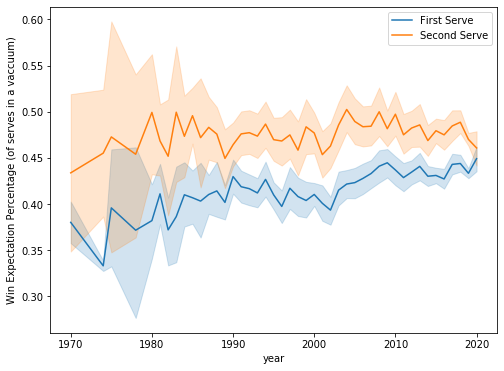

<IPython.core.display.Javascript object>

In [19]:
# looking at how different serve metrics have changed with time:
plt.figure(figsize=(8, 6))
sns.lineplot(x="year", y="first_make_win", data=total_serve, label="First Serve")
plot = sns.lineplot(
    x="year", y="second_make_win", data=total_serve, label="Second Serve"
)
plot.set(ylabel="Win Expectation Percentage (of serves in a vaccuum)")

[Text(0, 0.5, 'Win Expectation Percentage (of serves in a vaccuum)')]

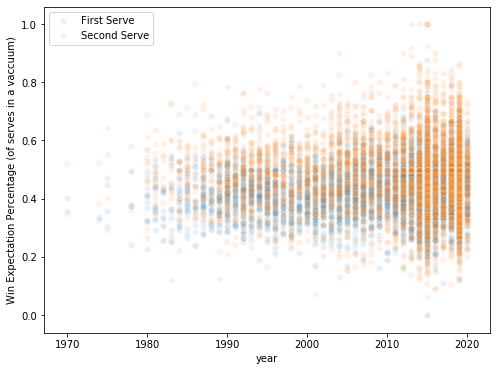

<IPython.core.display.Javascript object>

In [34]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="year", y="first_make_win", data=total_serve, label="First Serve", alpha=0.1
)
plot = sns.scatterplot(
    x="year", y="second_make_win", data=total_serve, label="Second Serve", alpha=0.1
)
plot.set(ylabel="Win Expectation Percentage (of serves in a vaccuum)")

~~Most interesting thing here is that we see a divergence in first and second serve success parameters around the years 2000-2005. This is a time period where tennis was undergoing a big transition. New types of strings were becoming popular, which improved spin performance and larger racketheads were becoming popular. The game started to move away from the big serve-forehand combo that had dominated the 90s. The net effect seems to be that players because better at returning second serves, while first serve success remained relatively constant.~~

~~One huge problem is that the percentages are too low. You would expect them to be above .5, because being the server confers an advantage.~~

**The above is probably the most interesting/important/satisfying graph here. You can see the slow convergence of the expectation of winning the point for first and second serves were you to hit them in a vaccuum.**

[Text(0, 0.5, 'Serve Win Percentage')]

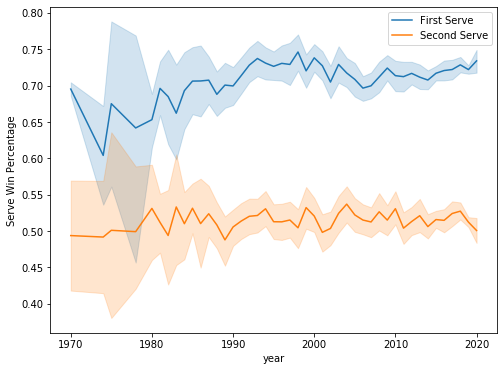

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    x="year", y="first_win_pct", data=total_serve, label="First Serve",
)
plot = sns.lineplot(
    x="year", y="second_win_pct", data=total_serve, label="Second Serve"
)
plot.set(ylabel="Serve Win Percentage")

Players win much more of the first serves they do make

[Text(17.200000000000003, 0.5, 'Serve Make Percentage')]

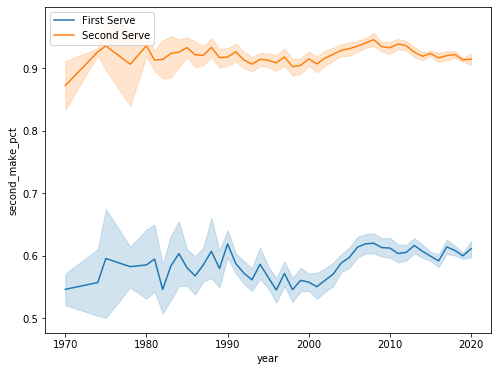

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(8, 6))
sns.lineplot(
    x="year", y="first_make_pct", data=total_serve, label="First Serve",
)
sns.lineplot(x="year", y="second_make_pct", data=total_serve, label="Second Serve")
plot.set(ylabel="Serve Make Percentage")

[Text(0, 0.5, 'Expectation of winning the point on either serve before the point starts')]

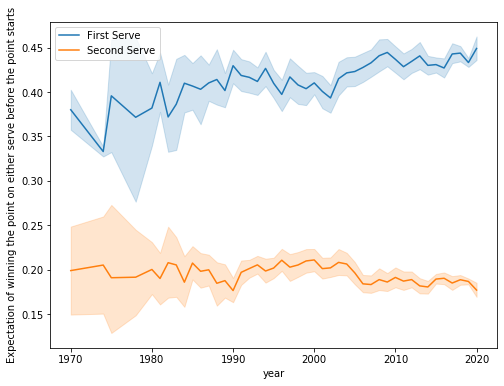

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(8, 6))
sns.lineplot(x="year", y="first_make_win", data=total_serve, label="First Serve")
plot = sns.lineplot(
    x="year", y="second_success", data=total_serve, label="Second Serve"
)
plot.set(
    ylabel="Expectation of winning the point on either serve before the point starts"
)

As suspected, players make almost all their second serves. (Double check this)

0.39697483006014284

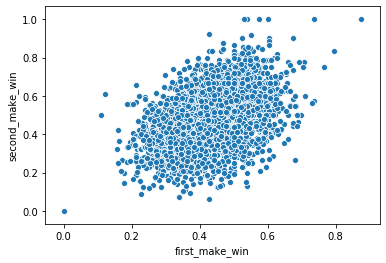

<IPython.core.display.Javascript object>

In [23]:
sns.scatterplot(x="first_make_win", y="second_make_win", data=total_serve)
plt.plot()
# seems like they're positively correlated
total_serve["first_make_win"].corr(total_serve["second_make_win"])

0.4224376994939962

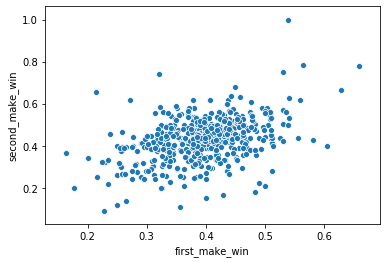

<IPython.core.display.Javascript object>

In [24]:
sns.scatterplot(x="first_make_win", y="second_make_win", data=player_sums)
# you can see a bit more of a positive correlation here.
plt.plot()
player_sums["first_make_win"].corr(player_sums["second_make_win"])

-0.027261410993612362

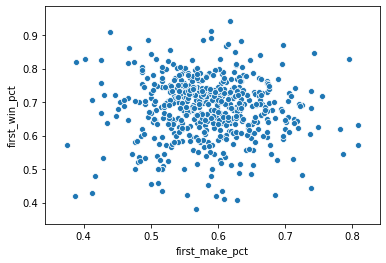

<IPython.core.display.Javascript object>

In [25]:
sns.scatterplot(x="first_make_pct", y="first_win_pct", data=player_sums)
plt.plot()
player_sums["first_make_pct"].corr(player_sums["first_win_pct"])

# stats.pearson_r(series['easdf'], series['asdf'])



TODO: next, plot miss percentage against a make win

## Now, for some statistical testing:

DescribeResult(nobs=5100, minmax=(0.0, 0.875), mean=0.42873496680247886, variance=0.007330046596637597, skewness=0.08133138043149396, kurtosis=0.41943019394125436)


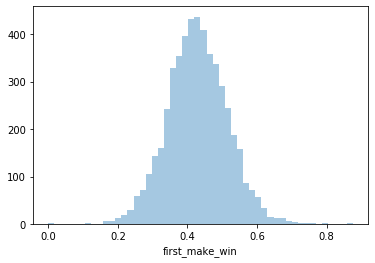

<IPython.core.display.Javascript object>

In [26]:
print(stats.describe(total_serve["first_make_win"]))
sns.distplot(total_serve["first_make_win"], kde=False)

DescribeResult(nobs=5100, minmax=(0.0, 1.0), mean=0.4771657670771601, variance=0.015122132695447339, skewness=0.19506426346034916, kurtosis=0.6031144820671446)


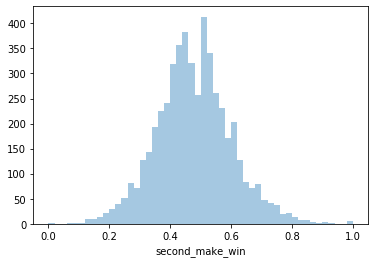

<IPython.core.display.Javascript object>

In [27]:
print(stats.describe(total_serve["second_make_win"]))
sns.distplot(total_serve["second_make_win"], kde=False)

**Both look quite normal, can do independent t-test**

In [28]:
stats.ttest_ind(total_serve["first_make_win"], total_serve["second_make_win"])

Ttest_indResult(statistic=-23.08221503737973, pvalue=5.972884331952519e-115)

<IPython.core.display.Javascript object>

In [29]:
def get_95_ci(x1, x2):
    """Calculate a 95% CI for 2 1d numpy arrays"""
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi


get_95_ci(total_serve["first_make_win"], total_serve["second_make_win"])

(-0.052543246518883396, -0.04431835403047593)

<IPython.core.display.Javascript object>

Seems like for second serves, P(make) * P(winning | you make it) is higher, so the tour as a whole should not transition to hitting second serves more aggressively. 

**Are there any players who should, however?**

In [30]:
#looking at top players who should be more aggressive on second serve
player_sums.sort_values(by="serve_pts", ascending=False).head(100).sort_values(by="make_win_diff").head(30)


,serve_pts,aces,dfs,first_in,first_won,second_in,second_won,year,first_out,second_total,second_out,matches_no,first_make_pct,first_win_pct,first_make_win,second_make_pct,second_win_pct,second_make_win,second_success,make_win_diff
player_id,,,,,,,,,,,,,,,,,,,,
Alexander_Zverev,3841,406,214,2422,1804,1205,554,102932,1419,1419,214,51,0.630565,0.744839,0.469669,0.849190,0.459751,0.390416,0.144233,-0.079254
Ivo_Karlovic,2504,555,117,1568,1278,819,424,54427,936,936,117,27,0.626198,0.815051,0.510383,0.875000,0.517705,0.452991,0.169329,-0.057392
Kevin_Anderson,2139,312,63,1351,1047,725,344,40328,788,788,63,20,0.631604,0.774981,0.489481,0.920051,0.474483,0.436548,0.160823,-0.052933
Jeremy_Chardy,1326,125,71,807,586,448,205,30254,519,519,71,15,0.608597,0.726146,0.441931,0.863198,0.457589,0.394990,0.154600,-0.046940
John_Isner,3349,633,76,2306,1777,967,525,74603,1043,1043,76,37,0.688564,0.770598,0.530606,0.927133,0.542916,0.503356,0.156763,-0.027250
Felix_Auger_Aliassime,1575,139,85,978,722,512,258,40381,597,597,85,20,0.620952,0.738241,0.458413,0.857621,0.503906,0.432161,0.163810,-0.026252
Nick_Kyrgios,3558,622,128,2284,1777,1146,608,74630,1274,1274,128,37,0.641934,0.778021,0.499438,0.899529,0.530541,0.477237,0.170883,-0.022201
Fernando_Verdasco,2454,215,89,1568,1087,797,373,50391,886,886,89,25,0.638957,0.693240,0.442950,0.899549,0.468005,0.420993,0.151997,-0.021957
Grigor_Dimitrov,3910,302,167,2372,1731,1371,650,90719,1538,1538,167,45,0.606650,0.729764,0.442711,0.891417,0.474106,0.422627,0.166240,-0.020084


<IPython.core.display.Javascript object>

You can see a lot of top players above. Zverev, Connors, Tomic, Isner, Dimitrov, Monfis, Roddick, Kyrgios, Tsitsipas, Querrey, Rublev are all highly ranked. Many are known for having a really big serve.

158
542


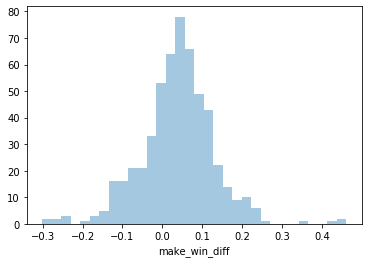

<IPython.core.display.Javascript object>

In [31]:
# make a list of all of the naively bad second servers
bad_servers = player_sums[player_sums["make_win_diff"] < 0].sort_values(
    by="make_win_diff"
)
print(bad_servers.count()[0])
print(player_sums.count()[0])
sns.distplot(player_sums["make_win_diff"], kde=False)

**So around 1/4 of recorded players have a better first than second serve in a vaccuum.**

**Perhaps it would be interesting to see if these guys have significantly worse mental game (as measured by a difference in win % after a double fault) than the other players. Another t-test!**

**I would also like to return a list of which of these players are significant, as far as their  first serve being significantly better than their second. Basically test if a bunch of first_make_wins are better than second_make_wins.**


Be careful of p-hacking here. 

Try to integrate **match** win percentages